In [1]:
import glob
import matplotlib.pyplot as plt
import rasterio as rio
import datetime
import numpy as np
import xarray as xr
import statistics

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [2]:
years = [2019,2020,2021,2022,2023]
# years = [2019,2020,2023]
year_select = 2021

# DOMID = 'GIN'
# DOMID = 'STR'
# DOMID = 'DPO'
# DOMID = 'TUM'
# DOMID = 'TUM'
# DOMID = '869'
# DOMID = '793'
# DOMID = '551'
DOMID = '737'
# DOMID = '551'
# DOMID = 'DAN'

# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/GIN/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/STR/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/DPO/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/TUM/'
data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/737/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/586/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/793/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/869/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/DAN/'
drop_idxs_file = data_direc+'drop_idx.txt'


In [4]:
def read_drop_idxs(file_path):
    # Initialize an empty list to store variables
    variables = []

    # Read the file line by line
    with open(file_path, 'r') as file:
        # Skip the first line (header)
        next(file)
        # Skip the years reference line
        next(file)

        # Process each line
        for line in file:
            # Evaluate the line to get the variable
            variable = eval(line)

            # Append the variable to the list
            variables.append(variable)
    return variables

def DSD_index(year,files):
    # instantiate
    data_list,daydiff = [],[]
    # set the reference date to the start of the water year
    ref_date = datetime.date(year-1,10,1)

    # loop through the snow cover observations
    for fCount,file in enumerate(files):
        # determine/log date
        breakFile = file.split('/')[-1].split('_')[0]
        dater = datetime.date(int(breakFile[0:4]),int(breakFile[4:6]),int(breakFile[6:8]))

        # determine how many days into the water year the PS obs is from
        daydiff.append((dater-ref_date).days)

        # read in and append the data
        with rio.open(file) as src:
            data = src.read(1)
            data_list.append(data)

    # create stacked dataframe for snow cover
    stacked_data = np.stack(data_list, axis=0).astype(float)
    daydiff = np.array(daydiff)
    # print(daydiff)
    return stacked_data,daydiff

# def DSD_smoother(stacked_data):
#     # smooth spurious melt out dates, assuming that they are not longer than 2 days in duration
#     stacked_data_averages = (stacked_data[:-3,:,:] + stacked_data[1:-2,:,:] + stacked_data[2:-1,:,:]) / 3.0
#     dsd = np.argmin(stacked_data_averages,axis=0)#.astype(float)
#     # dsd[dsd == 0] = np.nan
#     return dsd
def DSD_smoother(stacked_data):
    # smooth spurious melt out dates, assuming that they are not longer than 2 days in duration
    stacked_data_averages = stacked_data.copy()
    stacked_data_averages[1:-2,:,:] = (stacked_data[:-3,:,:] + stacked_data[1:-2,:,:] + stacked_data[2:-1,:,:]) / 3.0
    stacked_data_averages[0,:,:] = (stacked_data[0,:,:] + stacked_data[1,:,:]) / 2.0
    dsd = np.argmin(stacked_data_averages,axis=0)-1
    # dsd[dsd == 0] = np.nan
    return dsd,stacked_data_averages

def fill_DSDdates(daydiff,dsd):
    # determine the actual day since October 1 the observation came from
    dsd_date = daydiff[dsd].astype(float)
    # determine the snow-present day just before that
    temp = daydiff[dsd-1].astype(float)
    # and calculate the uncertainty
    temp[dsd == 0] = np.nan
    dsd_uncertain = dsd_date-temp
    # set the dsd as the halfway point
    dsd_date = np.ceil((dsd_date+temp)/2)#.astype(int)
    return dsd_date,dsd_uncertain

90


/var/folders/m4/q1120d2116gb0kq3xdjvyj3r0000gp/T/ipykernel_61780/3283756453.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fg,ax = plt.subplots()


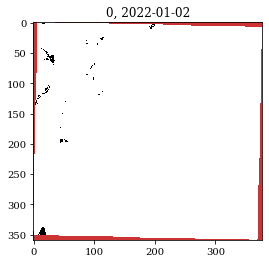

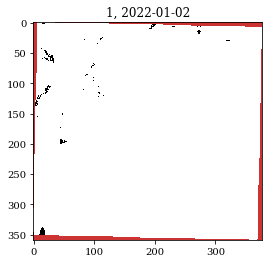

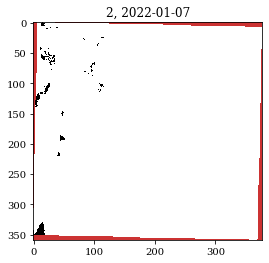

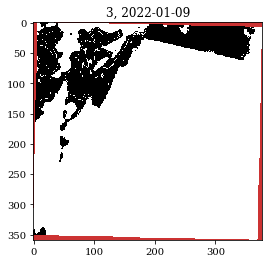

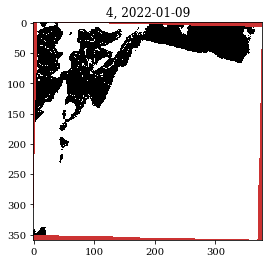

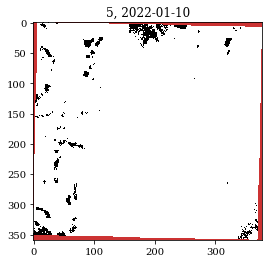

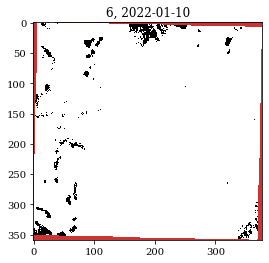

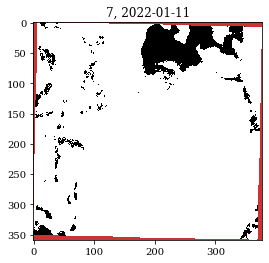

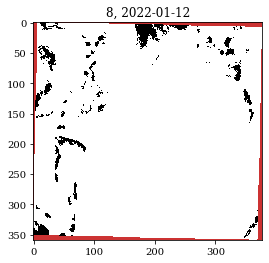

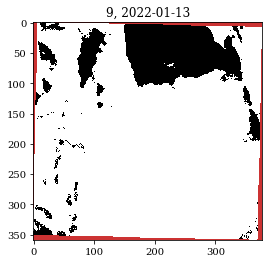

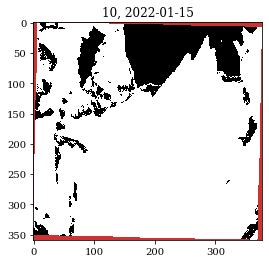

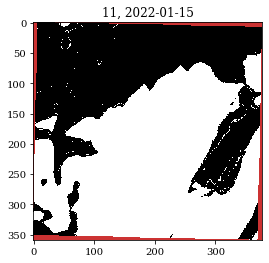

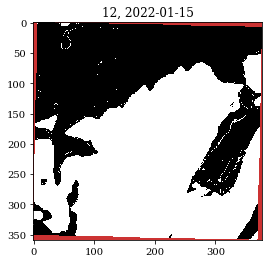

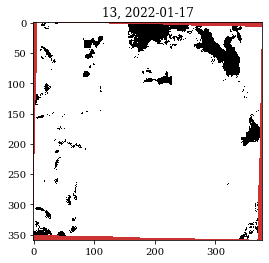

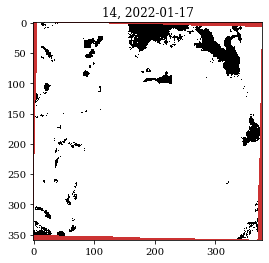

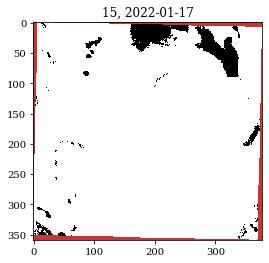

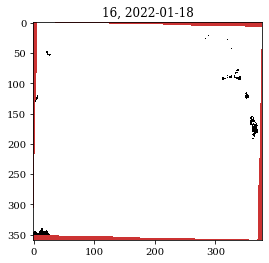

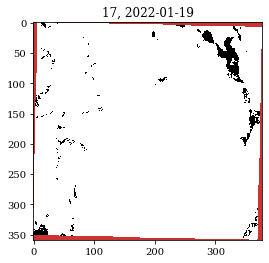

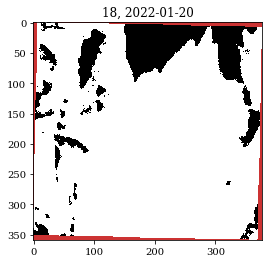

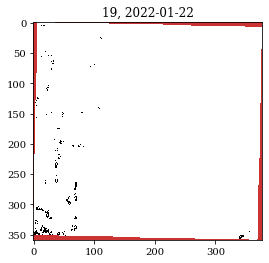

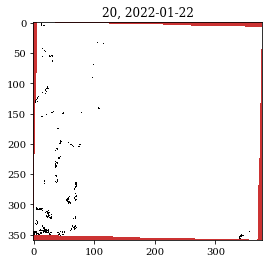

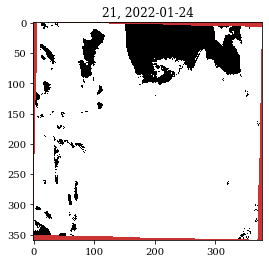

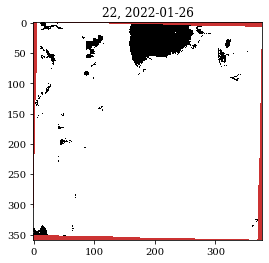

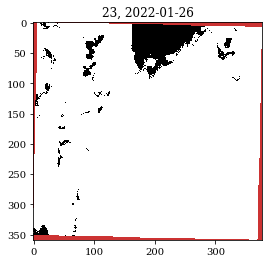

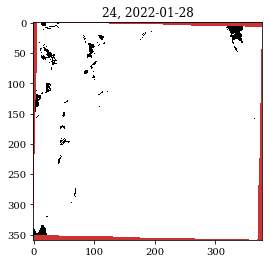

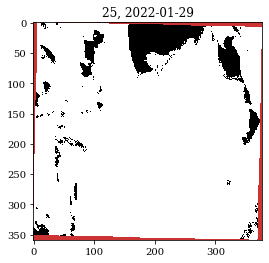

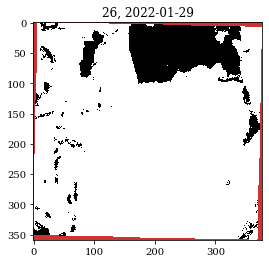

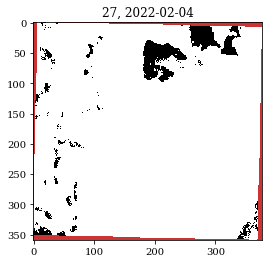

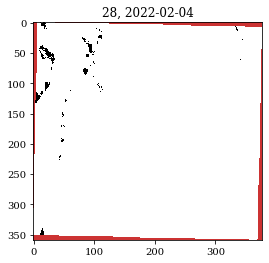

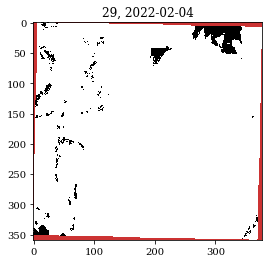

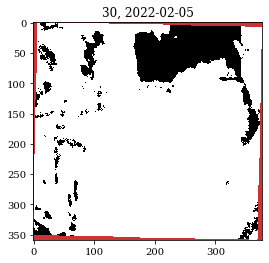

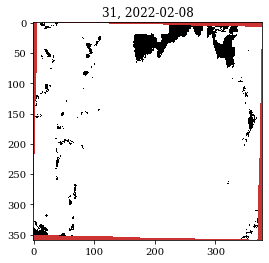

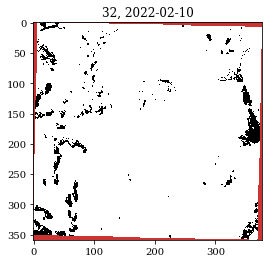

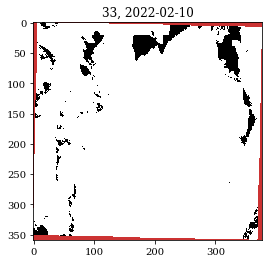

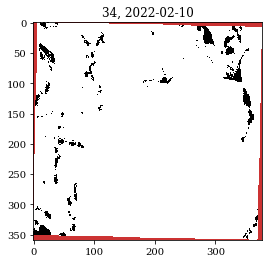

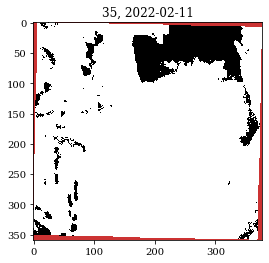

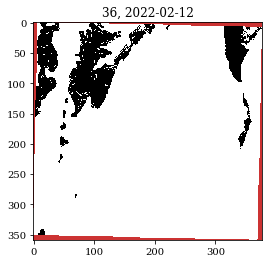

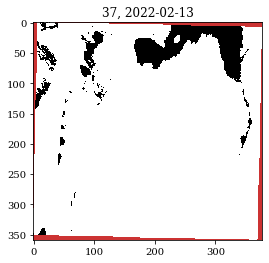

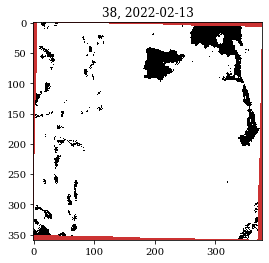

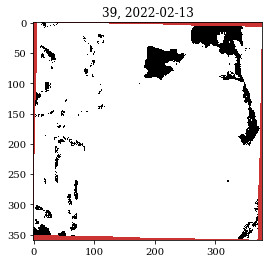

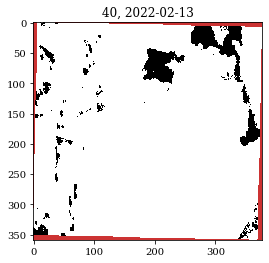

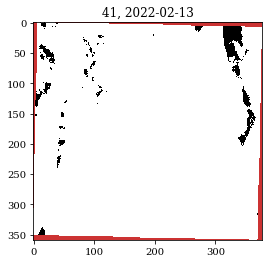

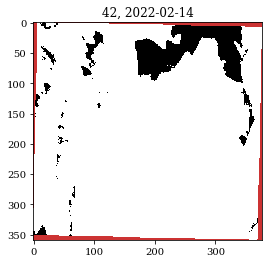

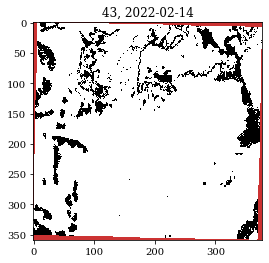

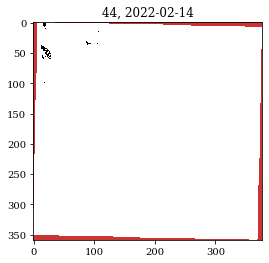

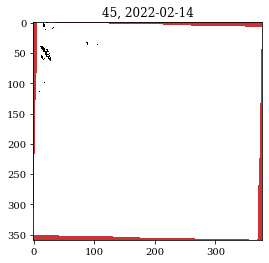

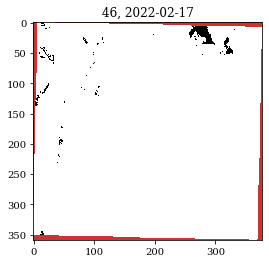

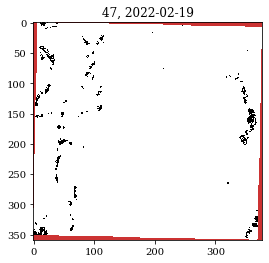

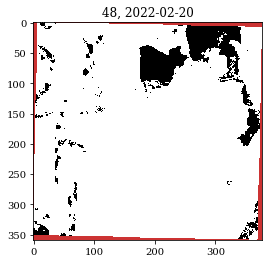

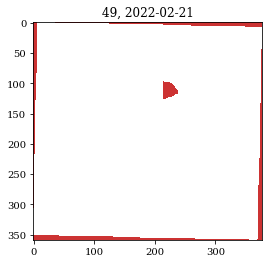

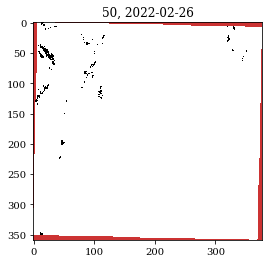

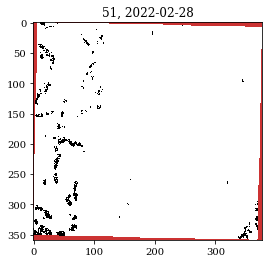

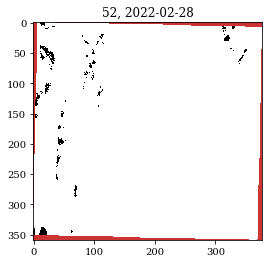

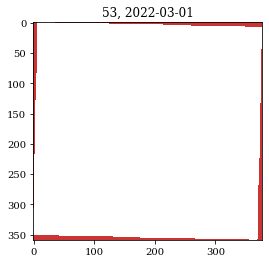

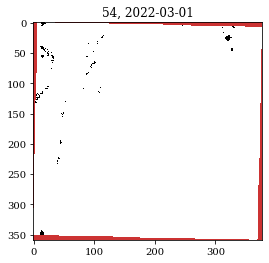

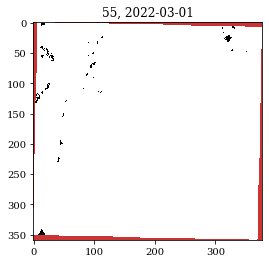

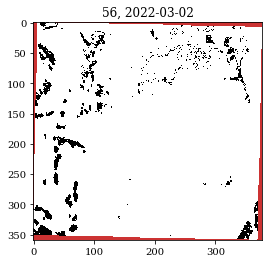

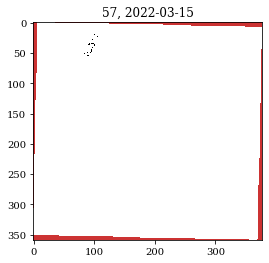

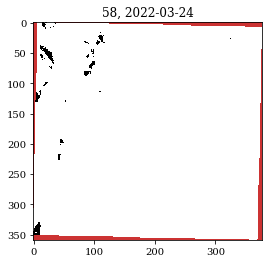

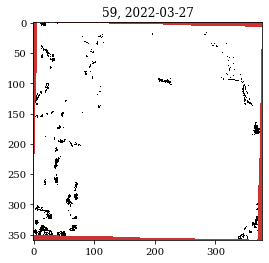

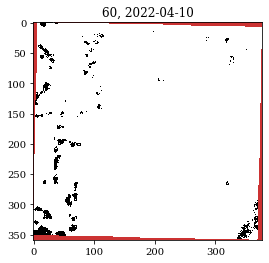

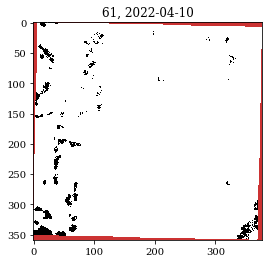

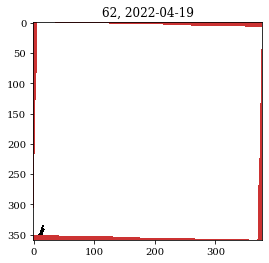

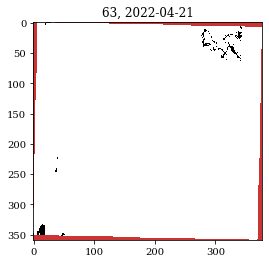

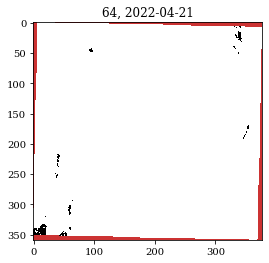

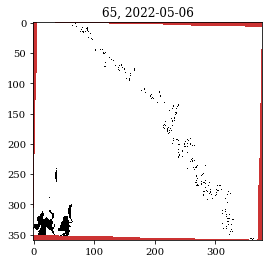

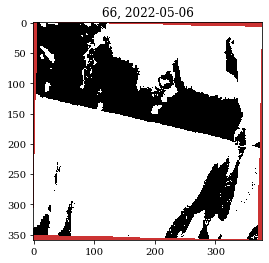

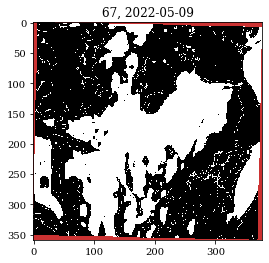

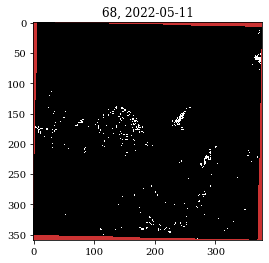

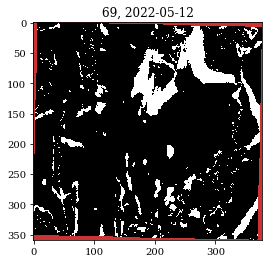

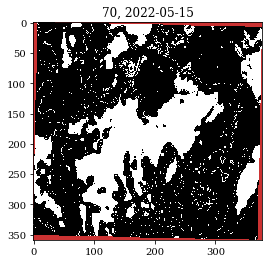

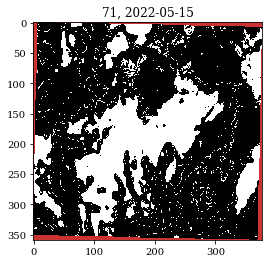

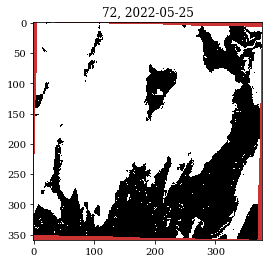

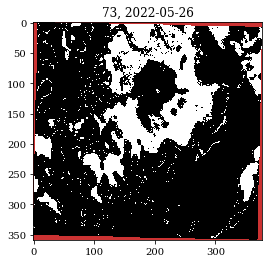

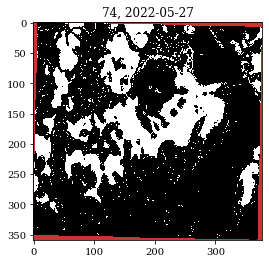

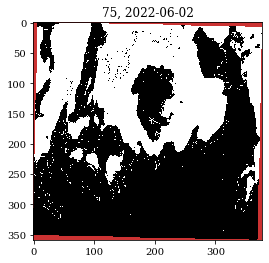

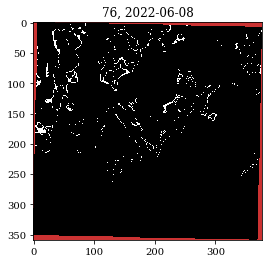

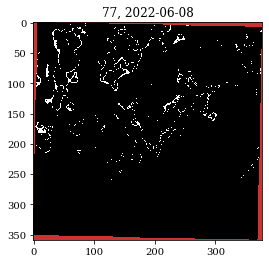

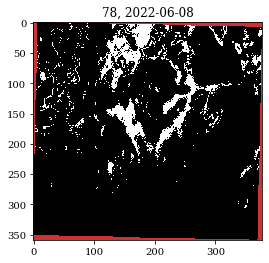

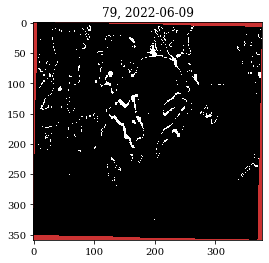

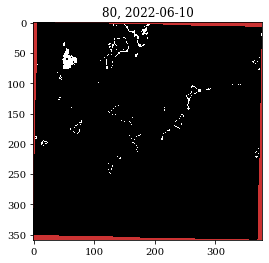

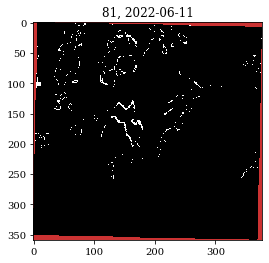

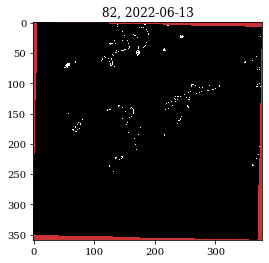

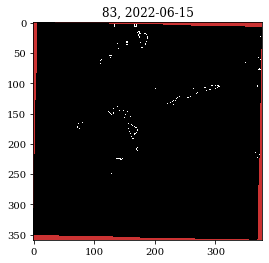

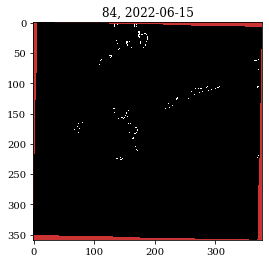

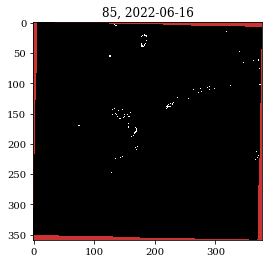

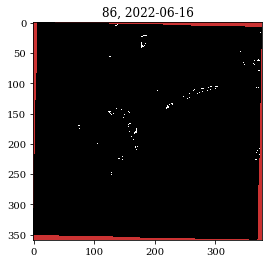

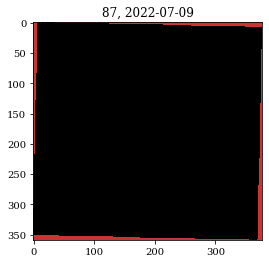

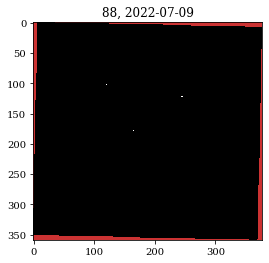

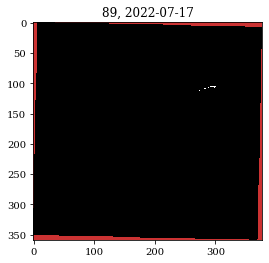

In [5]:
#change the year here to do a visual inspection
#don't have to do if already defined the drop variables
year_select = 2022

# identify all available fSCA observations for a given year
files = sorted(glob.glob(data_direc+'*'+str(year_select)+'*SCA.tif'))
print(len(files))

for fileCount,file in enumerate(files):
    breakFile = file.split('/')[-1].split('_')[0]
    dater = datetime.date(int(breakFile[0:4]),int(breakFile[4:6]),int(breakFile[6:8]))
    
    fg,ax = plt.subplots()
    with rio.open(file) as src:
        data = src.read(1)
        ax.imshow(data,vmin=0,vmax=1,cmap='Greys_r',interpolation='none')
        ax.set_facecolor([0.8,0.2,0.2])
        ax.set_title(str(fileCount)+', '+str(dater))
    # break

In [7]:
for year_index,testing_year in enumerate(years):
    print(year_index)

    # read the bad scenes to drop based on the indexed files
    drop_idxs = read_drop_idxs(drop_idxs_file)
    ref_pts = drop_idxs[-1]
    drop_idxs = drop_idxs[year_index]
    # drop_idxs

    files = sorted(glob.glob(data_direc+'*'+str(testing_year)+'*SCA.tif'))
    files = [files[i] for i in range(len(files)) if i not in drop_idxs]
    # print(files)

    # initialize
    ref_date = datetime.date(testing_year-1,10,1)
    data_list,daydiff = [],[]

    # loop through the good planet scenes
    for fCount,file in enumerate(files):
        # determine the date from the filename and append to the record
        breakFile = file.split('/')[-1].split('_')[0]
        dater = datetime.date(int(breakFile[0:4]),int(breakFile[4:6]),int(breakFile[6:8]))
        daydiff.append((dater-ref_date).days)

        # read in and store the data
        with rio.open(file) as src:
            data = src.read(1)
            data_list.append(data)
            
    # create stacked dataframe for snow cover
    stacked_data = np.stack(data_list, axis=0).astype(float)
    daydiff = np.array(daydiff)
    print(stacked_data.shape)
    print(daydiff.shape)
    
    dsd,stacked_data = DSD_smoother(stacked_data)#.astype(float)
    print(stacked_data.shape)
    
    # save the data if this is a modeling year
    # if testing_year == year_select:
    #     np.save(data_direc+str(year_select)+'/DSD_stacked.npy',stacked_data)
    #     np.save(data_direc+str(year_select)+'/DSD_daydiff.npy',daydiff)

    # determine the actual dsd date and uncertainty
    dsd_masked = dsd.copy()
    dsd,dsd_uncertain = fill_DSDdates(daydiff,dsd)
    # mask values where snow was never observed
    dsd[dsd_masked == -1] = np.nan

    # calculate the date of snow disappearance anomaly
    # dsd[dsd < 90] = np.nan
    # dsd_anomaly = dsd-dsd[ref_pts[1],ref_pts[0]]
    # dsd_anomaly = dsd-statistics.mode(dsd[~np.isnan(dsd)])
    dsd_anomaly = dsd-np.nanmedian(dsd)
        
    # append the data
    if year_index == 0:
        shpp = dsd_anomaly.shape
        dsd_saver = np.empty((len(years),shpp[0],shpp[1]))
        dsd_anomaly_saver = np.empty((len(years),shpp[0],shpp[1]))
        dsd_uncertain_saver = np.empty((len(years),shpp[0],shpp[1]))    
    dsd_saver[year_index,:,:] = dsd
    dsd_anomaly_saver[year_index,:,:] = dsd_anomaly
    dsd_uncertain_saver[year_index,:,:] = dsd_uncertain
    
    if year_index == 2:
        break
    # break
    
        

0
(21, 359, 378)
(21,)
(21, 359, 378)
1
(38, 359, 378)
(38,)
(38, 359, 378)
2
(28, 359, 378)
(28,)
(28, 359, 378)


datetime.timedelta(days=250)

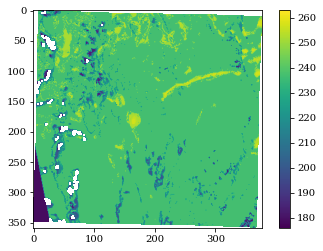

In [29]:
# np.unique(dsd_uncertain_saver[2,:,:])
ref = dsd_uncertain_saver[2,:,:]
plt.imshow(dsd)
plt.colorbar()

# np.unique(dsd[ref == 27])
# 237
# daydiff

datetime.date(2021,6,8)-datetime.date(2020,10,1)


In [22]:
daydiff

array([174, 177, 181, 189, 210, 210, 223, 250, 250, 251, 253, 253, 253,
       256, 256, 257, 257, 257, 257, 258, 258, 258, 258, 262, 262, 263,
       275, 280])

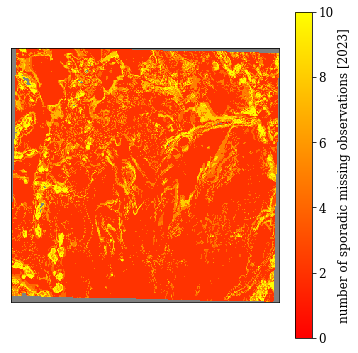

In [6]:
temp = stacked_data.copy()
temp[temp == 1] = 0
temp[temp > 0] = 1
temp = np.sum(temp,axis=0)
temp[np.isnan(dsd)] = np.nan
# temp[temp > 10] = 10

fg,ax = plt.subplots(figsize=(6,6))
out = ax.imshow(temp,cmap='autumn',interpolation='none',vmin=0,vmax=10)
cbar = fg.colorbar(out)
cbar.ax.tick_params(labelsize=12)  # You can change the font size (here, 12) to your desired value
cbar.set_label('number of sporadic missing observations [2023]',fontsize=12)

ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor([0.5,0.5,0.5])

# fg.savefig('/Users/jpflug/Documents/Projects/cubesatReanaly/ppts/figs/'+DOMID+'_sporadicMissing.svg',format='svg',bbox_inches='tight',dpi=1200)


In [7]:
# plt.imshow(np.mean(dsd_anomaly_saver,axis=0),vmin=-20,vmax=20,cmap='RdBu',interpolation='none')

ds = xr.open_dataset(files[0])
ds_temp = ds.copy(deep=True)
ds_temp['band_data'][0,:,:] = np.mean(dsd_anomaly_saver,axis=0)
ds_temp['band_data'].rio.to_raster(data_direc+'avgDSD_anomaly.tif')

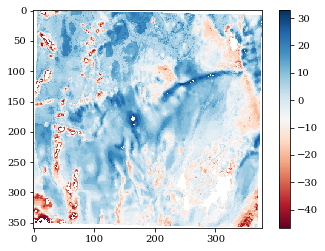

In [8]:
# plt.imshow(np.sum(stacked_data,axis=0))
# plt.imshow(np.mean(dsd_anomaly_saver,axis=0),vmin=-20,vmax=20,cmap='RdBu',interpolation='none')
plt.imshow(np.mean(dsd_anomaly_saver,axis=0),cmap='RdBu',interpolation='none')
plt.colorbar()

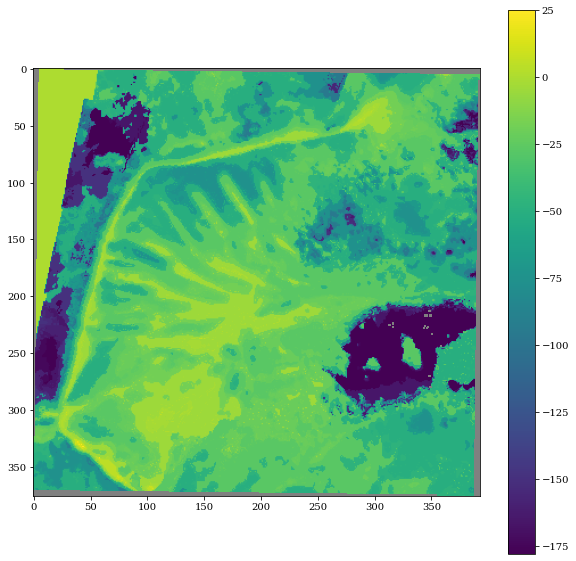

In [26]:
fg,ax = plt.subplots(figsize=(10,10))
# out = ax.imshow(np.mean(dsd_saver,axis=0),vmin=200,vmax=240,cmap='RdBu',interpolation='none')
# out = ax.imshow(dsd,interpolation='none')
out = ax.imshow(dsd_anomaly)
# ax.scatter(160,200,60,c='r',edgecolor='r')
fg.colorbar(out)
ax.set_facecolor([0.5,0.5,0.5])

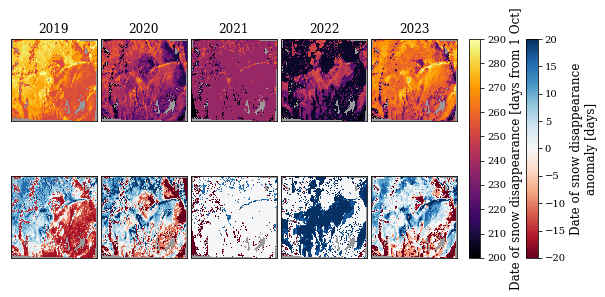

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

mask = np.sum(dsd_saver,axis=0)

# fg,ax = plt.subplots(2,len(years),figsize=(10,5),
#                      sharex='col', sharey='row', gridspec_kw={'height_ratios': [1, 1],'hspace': 0.02, 'wspace': 0.05})
fg,ax = plt.subplots(2,len(years),figsize=(8,5),
                     sharex='col', sharey='row', gridspec_kw={'height_ratios': [1, 1],'hspace': 0.02, 'wspace': 0.05})

for idx,year in enumerate(years):
    data = dsd_anomaly_saver[idx,:,:]
    data[np.isnan(mask)] = np.nan
    try:
        out1 = ax[1,idx].imshow(data,vmin=-20,vmax=20,interpolation='none',cmap='RdBu')
        ax[0,idx].set_title(year)
    except:
        out1 = ax[1].imshow(data,vmin=-20,vmax=20,interpolation='none',cmap='RdBu')
        ax[0].set_title(year)
    
for idx,year in enumerate(years):
    # data = dsd_uncertain_saver[idx,:,:]
    data = dsd_saver[idx,:,:]
    data[np.isnan(mask)] = np.nan
    try:
        out2 = ax[0,idx].imshow(data,vmin=200,vmax=290,interpolation='none',cmap='inferno')
    except:
        out2 = ax[0].imshow(data,vmin=0,vmax=14,interpolation='none',cmap='Greens')
 
# try:
#     ax[0,0].set_ylabel('Date of snow\ndisappearance\nanomaly [days]',fontsize=13)
#     ax[1,0].set_ylabel('Date of snow\ndisappearance\nuncertainty [days]',fontsize=13)
# except:
#     ax[0].set_ylabel('Date of snow\ndisappearance\nanomaly [days]',fontsize=13)
#     ax[1].set_ylabel('Date of snow\ndisappearance\nuncertainty [days]',fontsize=13)
    
for axx in np.ravel(ax):
    axx.set_xticks([])
    axx.set_yticks([])
    axx.set_facecolor([0.6,0.6,0.6])
    
pos_bott = ax[1,-1].get_position()
pos_top = ax[0,-1].get_position()

cax1 = fg.add_axes([pos_bott.x1 + 0.02,pos_bott.y0,0.02,pos_top.y1-pos_bott.y0])
cbar1 = fg.colorbar(out2, cax=cax1, orientation='vertical')
cbar1.set_label('Date of snow disappearance [days from 1 Oct]',fontsize=12)
  
cax2 = fg.add_axes([pos_bott.x1 + 0.12,pos_bott.y0,0.02,pos_top.y1-pos_bott.y0])
cbar2 = fg.colorbar(out1, cax=cax2, orientation='vertical')
cbar2.set_label('Date of snow disappearance\nanomaly [days]',fontsize=12)

fg.savefig('/Users/jpflug/Documents/Projects/cubesatReanaly/ppts/figs/'+DOMID+'_DSDmaps.svg',format='svg',bbox_inches='tight',dpi=1200)


In [75]:
'/Users/jpflug/Documents/Projects/cubesatReanaly/ppts/figs/'+DOMID+'_DSDmaps.svg'

'/Users/jpflug/Documents/Projects/cubesatReanaly/ppts/figs/GINDSDmaps.svg'

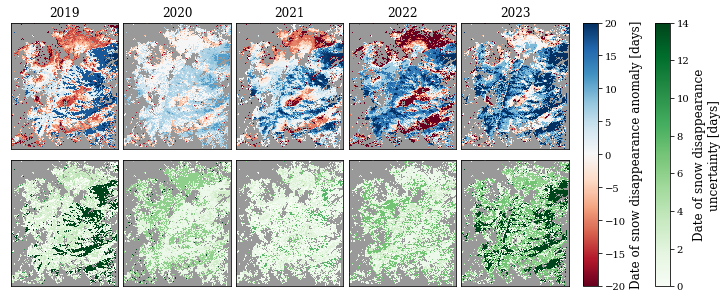

In [58]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

mask = np.sum(dsd_saver,axis=0)

fg,ax = plt.subplots(2,len(years),figsize=(10,5),
                     sharex='col', sharey='row', gridspec_kw={'height_ratios': [1, 1],'hspace': 0.02, 'wspace': 0.05})

for idx,year in enumerate(years):
    data = dsd_anomaly_saver[idx,:,:]
    data[np.isnan(mask)] = np.nan
    try:
        out1 = ax[0,idx].imshow(data,vmin=-20,vmax=20,interpolation='none',cmap='RdBu')
        ax[0,idx].set_title(year)
    except:
        out1 = ax[0].imshow(data,vmin=-20,vmax=20,interpolation='none',cmap='RdBu')
        ax[0].set_title(year)
    
for idx,year in enumerate(years):
    data = dsd_uncertain_saver[idx,:,:]
    data[np.isnan(mask)] = np.nan
    try:
        out2 = ax[1,idx].imshow(data,vmin=0,vmax=14,interpolation='none',cmap='Greens')
    except:
        out2 = ax[1].imshow(data,vmin=0,vmax=14,interpolation='none',cmap='Greens')
 
# try:
#     ax[0,0].set_ylabel('Date of snow\ndisappearance\nanomaly [days]',fontsize=13)
#     ax[1,0].set_ylabel('Date of snow\ndisappearance\nuncertainty [days]',fontsize=13)
# except:
#     ax[0].set_ylabel('Date of snow\ndisappearance\nanomaly [days]',fontsize=13)
#     ax[1].set_ylabel('Date of snow\ndisappearance\nuncertainty [days]',fontsize=13)
    
for axx in np.ravel(ax):
    axx.set_xticks([])
    axx.set_yticks([])
    axx.set_facecolor([0.6,0.6,0.6])
    
pos_bott = ax[1,-1].get_position()
pos_top = ax[0,-1].get_position()

cax1 = fg.add_axes([pos_bott.x1 + 0.02,pos_bott.y0,0.02,pos_top.y1-pos_bott.y0])
cbar1 = fg.colorbar(out1, cax=cax1, orientation='vertical')
cbar1.set_label('Date of snow disappearance anomaly [days]',fontsize=12)
  
cax2 = fg.add_axes([pos_bott.x1 + 0.12,pos_bott.y0,0.02,pos_top.y1-pos_bott.y0])
cbar2 = fg.colorbar(out2, cax=cax2, orientation='vertical')
cbar2.set_label('Date of snow disappearance\nuncertainty [days]',fontsize=12)

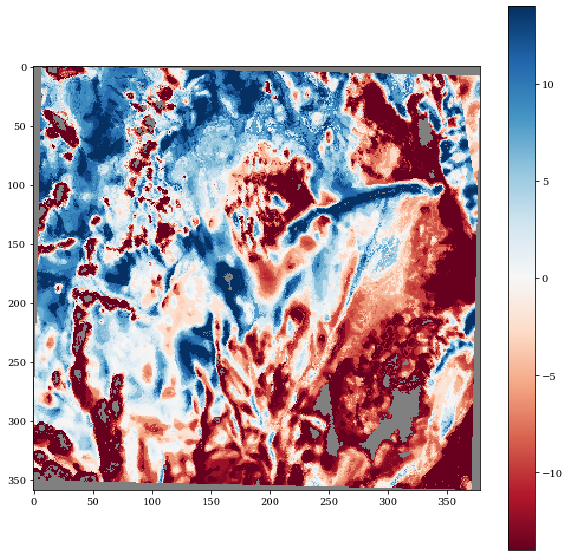

In [8]:
fg,ax = plt.subplots(figsize=(10,10))
out = ax.imshow(np.mean(dsd_anomaly_saver,axis=0),vmin=-14,vmax=14,interpolation='none',cmap='RdBu')
ax.set_facecolor([0.5,0.5,0.5])
fg.colorbar(out)

In [10]:
######## REMEMBER TO SAVE THE DATA!!! ##############
# np.save(data_direc+str(year_select)+'/DSD.npy',dsd_saver)
# np.save(data_direc+str(year_select)+'/DSD_anomaly.npy',dsd_anomaly_saver)
np.save(data_direc+'/DSD_uncertain_saver.npy',dsd_uncertain_saver)

# holder = xr.open_dataset(files[0])
# holder['band_data'][0,:,:] = np.mean(dsd_anomaly_saver,axis=0)
# holder['band_data'].rio.to_raster(data_direc+'averageDSD_anomaly.tif')

### TEMPORARY SCRIPTS BEYOND THIS

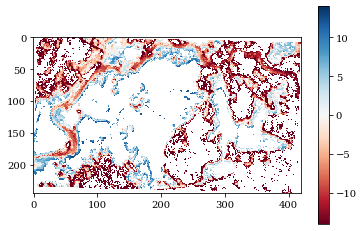

In [110]:
plt.imshow(np.mean(dsd_anomaly_saver,axis=0),vmin=-14,vmax=14,cmap='RdBu',interpolation='none')
plt.colorbar()

holder = xr.open_dataset(files[0])
holder['band_data'][0,:,:] = np.mean(dsd_anomaly_saver,axis=0)
holder['band_data'].rio.to_raster(data_direc+'averageDSD_anomaly.tif')

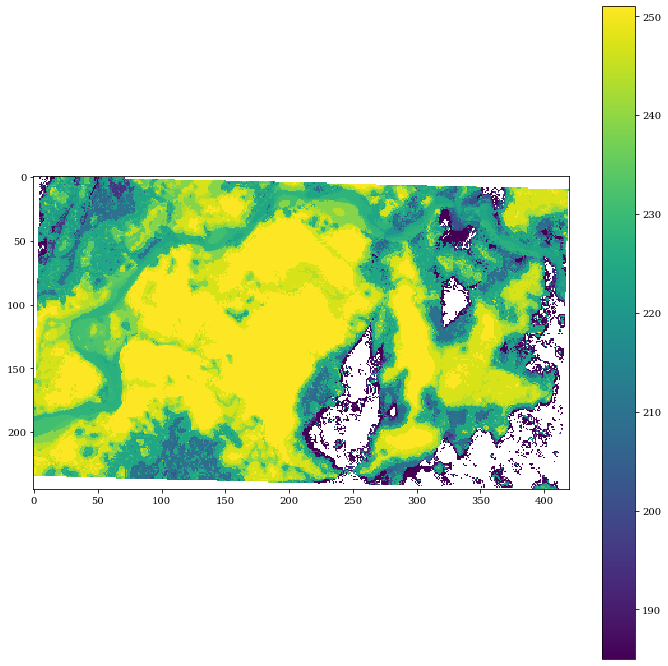

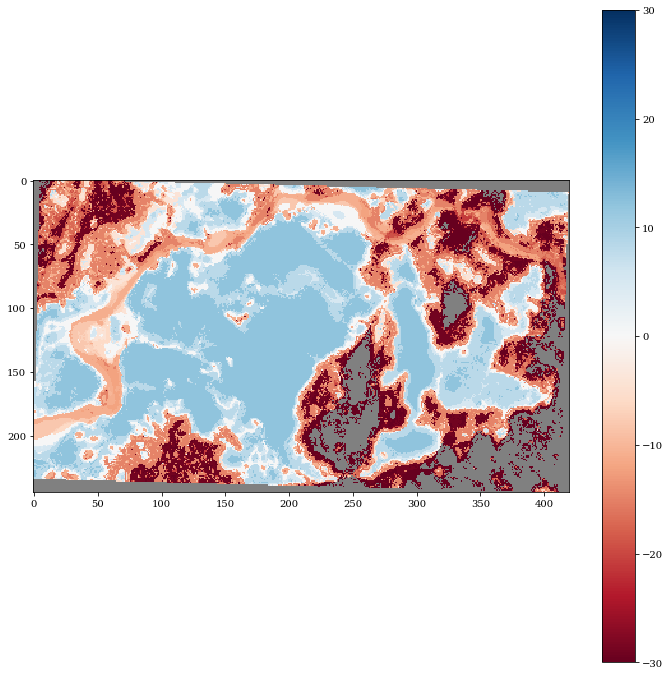

In [111]:
fg,ax = plt.subplots(figsize=(12,12))
out = ax.imshow(dsd,interpolation='none')
# ax.scatter(550,200,80,'r')
fg.colorbar(out)

fg,ax = plt.subplots(figsize=(12,12))
out = ax.imshow(dsd_anomaly,vmin=-30,vmax=30,cmap='RdBu',interpolation='none')
# ax.scatter(550,200,80,'k')
ax.set_facecolor([0.5,0.5,0.5])
fg.colorbar(out)

(array([ 11830.,  12421.,  39992.,   7525.,  20496.,  26149., 116462.,
         68103.,   9085.,  14767.]),
 array([20., 26., 32., 38., 44., 50., 56., 62., 68., 74., 80.]),
 <BarContainer object of 10 artists>)

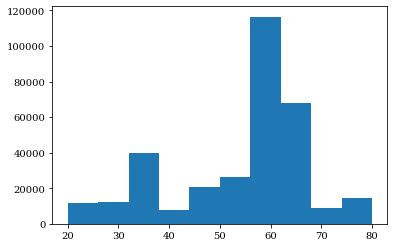

In [60]:
plt.hist(np.ravel(dsd))

2019
[215.]
2020
[113.]
2021
[109.]
2022
[111.]
2023
[235.]


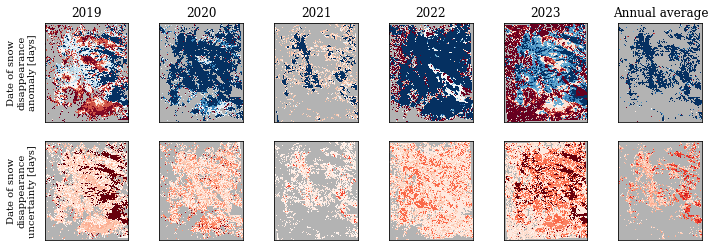

In [25]:
drop_idxs = read_drop_idxs(drop_idxs_file)
ref_idx = 12

y_loc,x_loc = [],[]
fg,ax = plt.subplots(2,len(years)+1,figsize=(12,4))
good_dsd = 0
for yearCount,year in enumerate(years):
    if len(drop_idxs[yearCount]) > 0:
        print(year)
        
        # find all the planet-defined snow cover maps
        # files = sorted(glob.glob(data_direc+shpp+str(year)+'/*SCA.tif'))
        files = sorted(glob.glob(data_direc+'*'+str(year)+'*SCA.tif'))
        files = [files[i] for i in range(len(files)) if i not in drop_idxs[yearCount]]
    
        # calculate the indices at which snow disappears
        stacked_data,daydiff = DSD_index(year,files)
        
        # smooth spurious melt out
        dsd = DSD_smoother(stacked_data)
        
        # calculate the day of the water year and uncertainty in disappearance
        dsd,dsd_uncertain = fill_DSDdates(daydiff,dsd)
        
        # filter for points that don't see snow
        dsd[np.isnan(dsd_uncertain)] = np.nan
        
        # identify a reference point
        if len(y_loc) == 0:
            reff = np.abs(dsd - np.nanmean(dsd))
            y_loc,x_loc = np.where(reff == np.nanmin(reff))
            y_loc = [y_loc[ref_idx]]
            x_loc = [x_loc[ref_idx]]
           
        print(dsd[y_loc,x_loc])
        dsd_anomaly = dsd - dsd[y_loc,x_loc]
        
        ax[0,yearCount].imshow(dsd_anomaly,cmap='RdBu',
                               vmin=-14,vmax=14,interpolation='none')
        ax[1,yearCount].imshow(dsd_uncertain,cmap='Reds',
                               vmin=0,vmax=14,interpolation='none')
        
        good_dsd += 1
        if good_dsd == 1:
            dsd_average = dsd_anomaly
            dsdUncertainty_average = dsd_uncertain
        else:
            dsd_average += dsd_anomaly
            dsdUncertainty_average += dsd_uncertain
        

        
        # break
    ax[0,yearCount].set_title(year)
    
ax[0,-1].imshow(dsd_average/good_dsd,cmap='RdBu',
                               vmin=-14,vmax=14,interpolation='none')
ax[1,-1].imshow(dsdUncertainty_average/good_dsd,cmap='Reds',
                               vmin=0,vmax=14,interpolation='none')

ax[0,0].set_ylabel('Date of snow\ndisappearance\nanomaly [days]')
ax[1,0].set_ylabel('Date of snow\ndisappearance\nuncertainty [days]')
ax[0,-1].set_title('Annual average')

for axx in np.ravel(ax):
    axx.set_facecolor([0.7,0.7,0.7])
    axx.invert_yaxis()
    axx.set_xticks([])
    axx.set_yticks([])
    

In [51]:
plt.imshow(dsd_uncertainty)

NameError: name 'dsd_uncertainty' is not defined

In [11]:
(62185*0.8)*9

447732.0

In [19]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

base_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/'
DOMIDs = ['DAN','DPO','GIN','STR','551','737','869']

for DOMID in DOMIDs:
    classmap = np.load(base_direc+DOMID+'/classified_quartile.npy')
    print(DOMID,len(classmap[~np.isnan(classmap)]))
    # break



DAN 113670
DPO 210618
GIN 326006
STR 107034
551 62185
737 127176
869 84256


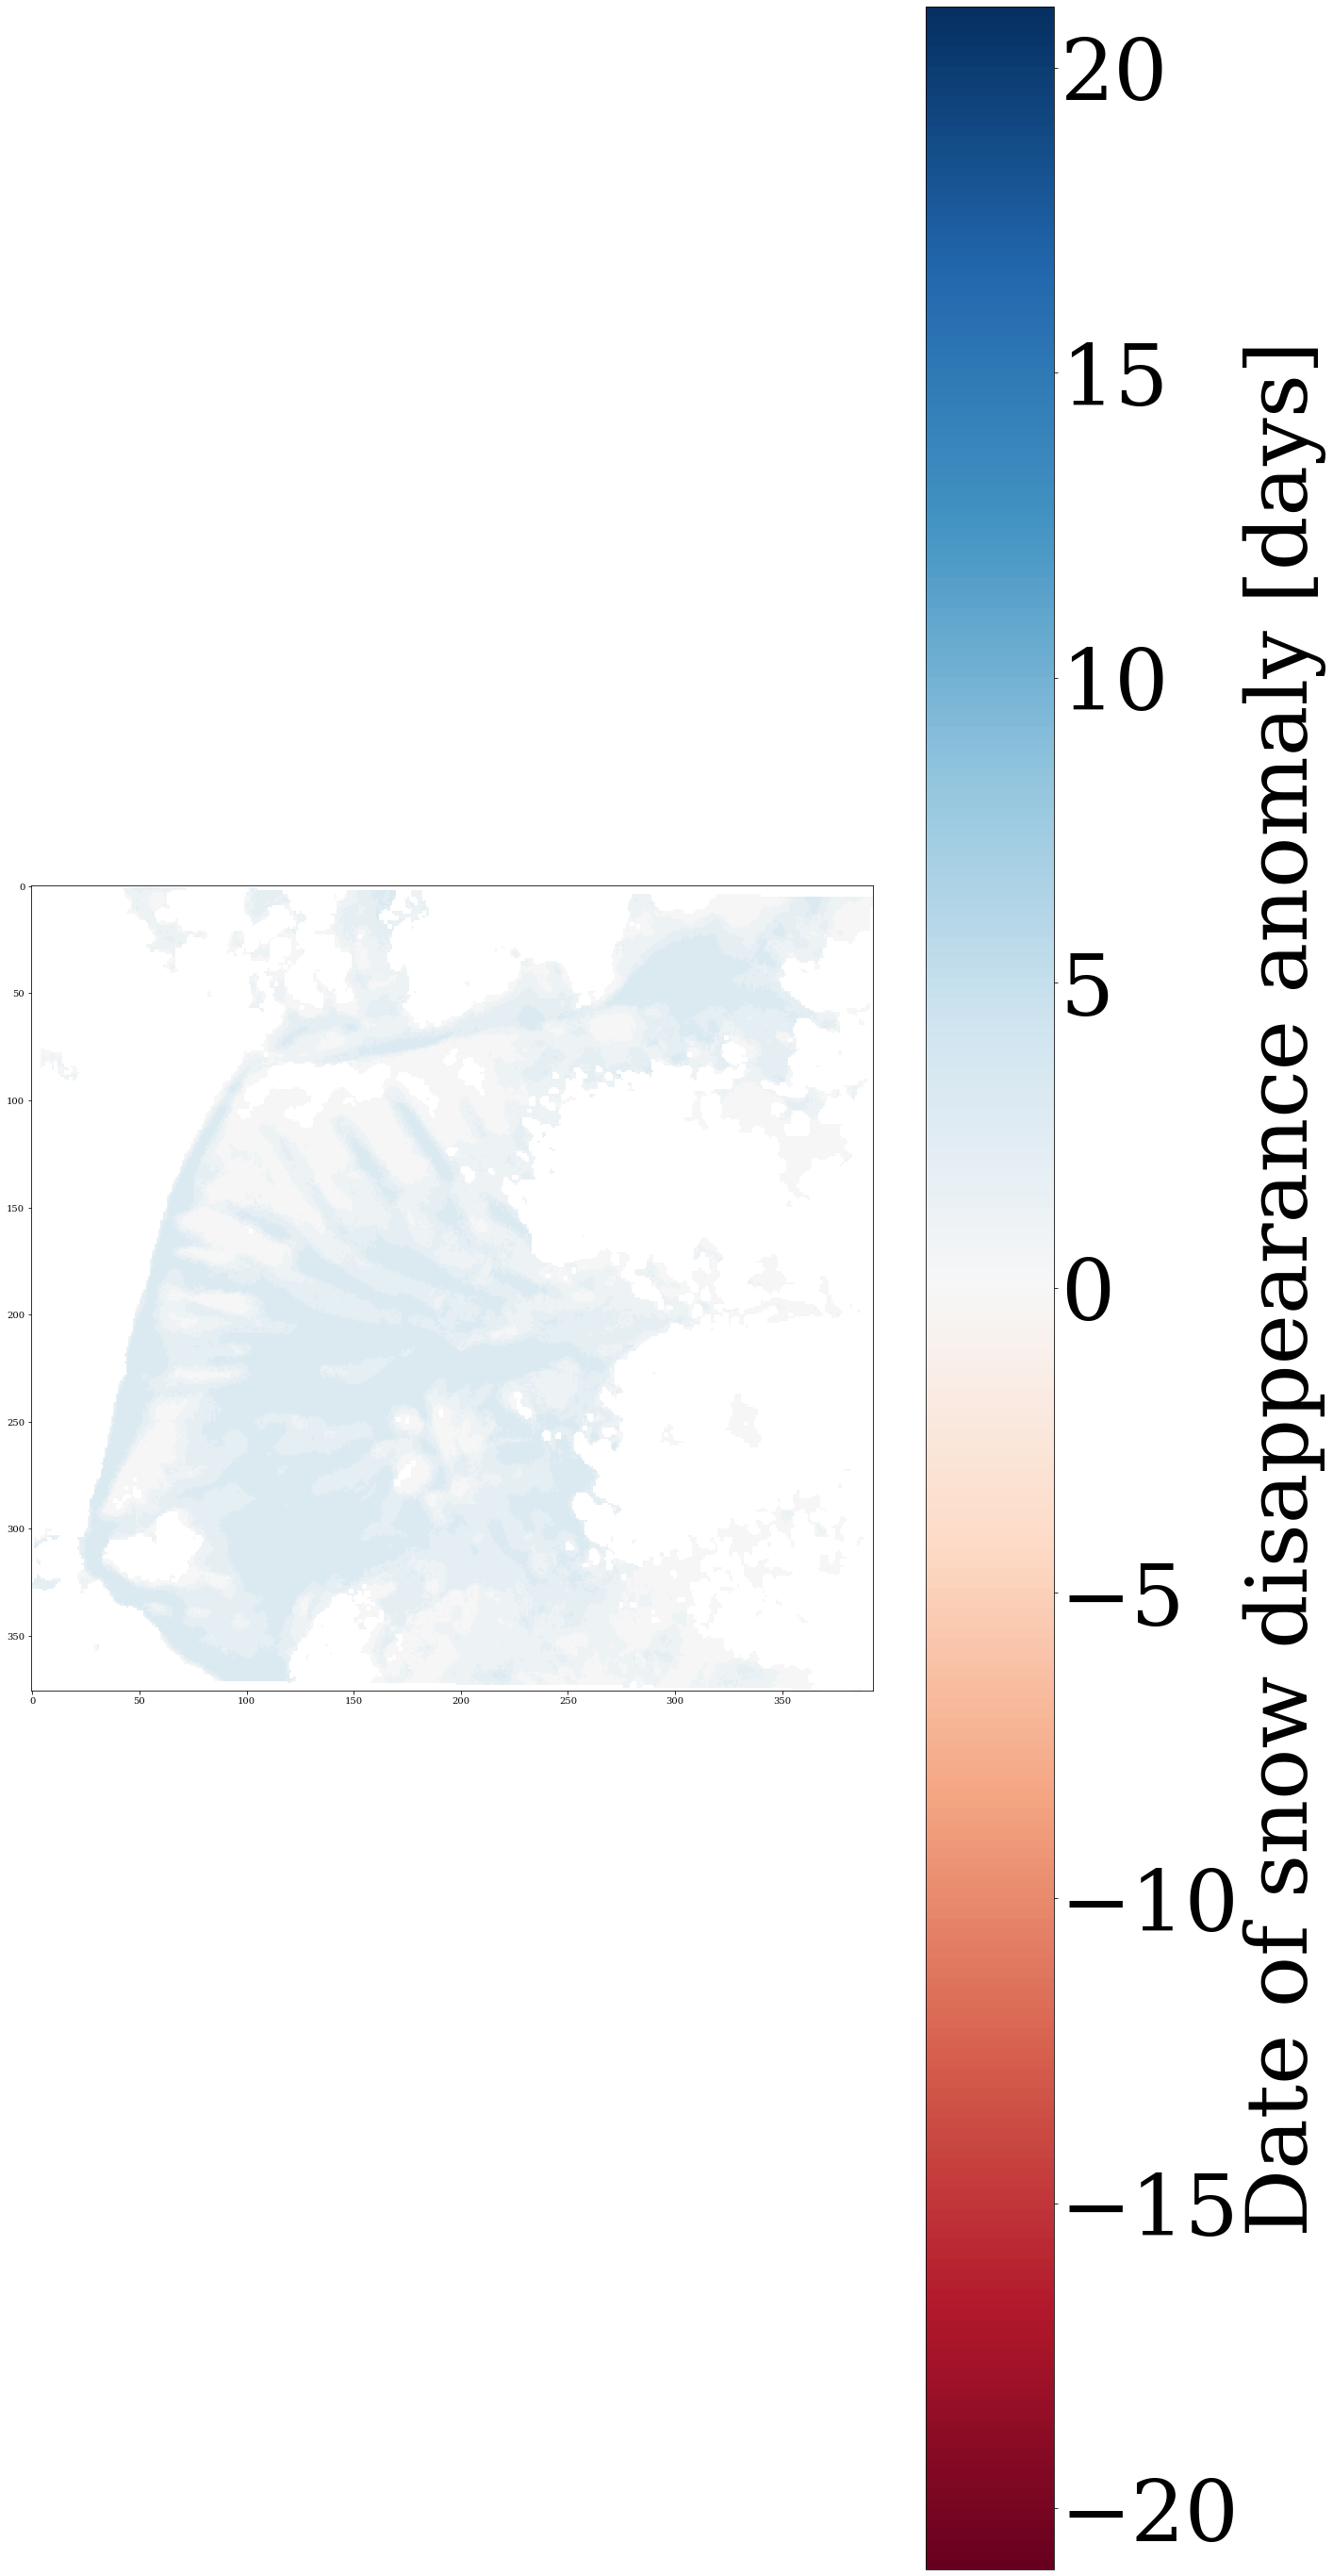

In [28]:
fg,ax = plt.subplots(figsize=(20,50))

out = ax.imshow(classmap,vmin=-21,vmax=21,cmap='RdBu')
cbar = fg.colorbar(out)
cbar.ax.tick_params(labelsize=90)  # You can change the font size (here, 12) to your desired value
cbar.set_label('Date of snow disappearance anomaly [days]',fontsize=90)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

DAN
DPO
GIN
STR
551
737


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (7).

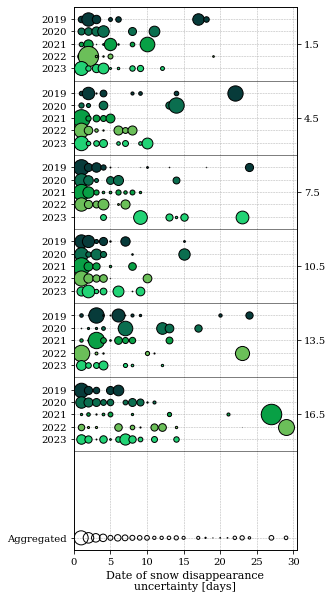

In [43]:
DOMIDs = ['DAN','DPO','GIN','STR','551','737','869']
# cols = ['#758467','#819171','#9CAF88','#CBD5C0','#DFE6DA']
# cols = ['#013220','#014421','#355E3B','#8A9A5B','#BCB88A']
cols = ['#073B3A','#0B6E4F','#08A045','#6BBF59','#21D375']

base_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/'

loc_saver = []
loc_saver_right = []
# yrr_saver = np.empty(())
yrr_saver = []
fg,ax = plt.subplots(figsize=(4,10))
axloc = 0

gridCount = 0

summUp = np.zeros(31)
for DOMID in DOMIDs:
    print(DOMID)
    uncertainty = np.load(base_direc+DOMID+'/DSD_uncertain_saver.npy')
    gridCount += len(uncertainty[uncertainty > 0])
    if uncertainty.shape[0] < 5:
        # yrr_saver = np.hstack((yrr_saver,np.array([2019,2020,2023])))
        yrr_saver.append('2019')
        yrr_saver.append('2020')
        yrr_saver.append('2023')
        cols_set = [cols[0],cols[1],cols[4]]
        loc_saver_right.append(axloc+1)
    else:
        # yrr_saver = np.hstack((yrr_saver,np.array([2019,2020,2021,2022,2023])))
        yrr_saver.append('2019')
        yrr_saver.append('2020')
        yrr_saver.append('2021')
        yrr_saver.append('2022')
        yrr_saver.append('2023')
        cols_set = cols
        loc_saver_right.append(axloc+1.5)
    for yrr in np.arange(uncertainty.shape[0]):
        axloc += 0.5
        data = uncertainty[yrr,:,:]
        unique_vals = np.unique(data)
        unique_vals = unique_vals[unique_vals > 0]
        lenn = len(data[data > 0])
        for vall in unique_vals:
            width  = (len(data[data == vall])/lenn)
            if vall <= 30:
                summUp[int(vall)] = summUp[int(vall)]+width
            # ax.plot([vall,vall],[axloc-width,axloc+width])
            ax.scatter(vall,axloc,width*500,c=cols_set[yrr],alpha=1,edgecolor='k',linewidth=1)
            # ax.scatter(vall,axloc,width*500,c=cols[2],alpha=1,edgecolor='k',linewidth=1)
        loc_saver.append(axloc)
        
    ax.plot([0,35],[axloc+0.5,axloc+0.5],'-k',linewidth=0.5)
            
    axloc += 0.5
    
    if DOMID == '737':
        break

        # break
    # break
    
loc_saver.append(21.5)
yrr_saver.append('Aggregated')
plt.scatter(np.arange(0,31),np.ones(31)*21.5,(summUp/np.sum(summUp))*750,c='none',edgecolor='k') 
ax.set_xlim([0,30.5])
ax.set_yticks(loc_saver)
ax.set_ylim([0,22])
# ax.set_yticklabels(yrr_saver[1:].astype(int))
ax.set_yticklabels(yrr_saver)
ax.invert_yaxis()
ax.set_xlabel('Date of snow disappearance\nuncertainty [days]',fontsize=11)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

ax_right = ax.twinx()
ax_right.set_ylim([0,22])
ax_right.invert_yaxis()
ax_right.set_yticks(loc_saver_right)
ax_right.set_yticklabels(DOMIDs)

# fg.savefig('/Users/jpflug/Documents/Projects/cubesatReanaly/ppts/figs/DSDuncertainty_aggFig.svg',format='svg',bbox_inches='tight',dpi=1200)


In [47]:
ref = uncertainty[2,:,:]
for val in np.unique(ref):
    print(val,len(ref[ref == val]),len(ref[ref == val])/len(ref[ref > 0]))

0.0 2759 0.020753255154464696
1.0 1337 0.010056941696817433
2.0 3342 0.02513859323168576
3.0 399 0.003001286265542375
4.0 1952 0.014682984436939139
5.0 6065 0.04562105564038724
8.0 1352 0.010169772007552109
13.0 4773 0.035902604875773826
21.0 2491 0.01873735360267182
27.0 111232 0.8366894082426303


23.886598063903588
3.344377189861642


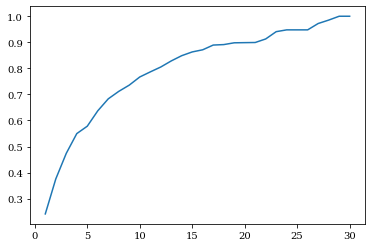

In [42]:
# plt.scatter(np.arange(0,31),np.ones(31)*21.5,(summUp/np.sum(summUp))*750,c='none',edgecolor='k') 

x_vals = np.arange(1,31)
y_vals = summUp/np.sum(summUp)
y_vals = np.cumsum(y_vals[1:])
print(np.sum(y_vals))
plt.plot(x_vals,y_vals)

from scipy.interpolate import interp1d
fx = interp1d(y_vals,x_vals)
print(fx(0.5))

14.416706770663579


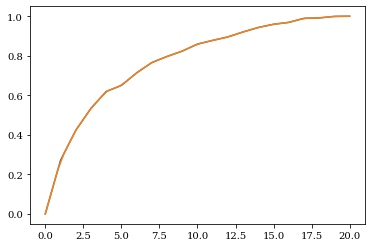

In [38]:
from scipy.interpolate import interp1d
test = (summUp/np.sum(summUp))
test = np.cumsum(test)
test_x = interp1d(np.arange(0,21),test)
test_y = interp1d(test,np.arange(0,21))

plt.plot(test)
xx = np.linspace(0,20)
plt.plot(xx,test_x(xx))

print(test_y(0.95))

In [68]:
np.arange(0,22).shape

(22,)

In [ ]:
# np.save(data_direc+'/DSD_uncertain_saver.npy',dsd_uncertain_saver)
# DOMID = 'GIN'
# DOMID = 'STR'
# DOMID = 'DPO'
# DOMID = 'TUM'
# DOMID = 'TUM'
# DOMID = '869'
# DOMID = '793'
# DOMID = '551'
# DOMID = '737'
DOMID = 'DAN'

# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/GIN/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/STR/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/DPO/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/TUM/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/737/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/586/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/793/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/869/'
data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/DAN/'
drop_idxs_file = data_direc+'drop_idx.txt'

In [12]:
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt

In [91]:
base_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/737/'

files = ['20210512_143738_1_0f2b/eb711cd3-ec74-424b-8de3-972f0204c34b/PSScene/20210512_143738_1_0f2b_3B_AnalyticMS_SR_clip.tif',
        '20210515_143458_0f36/169deaae-5ce6-4701-a50f-c9671fab54b5/PSScene/20210515_143458_0f36_3B_AnalyticMS_SR_clip.tif',
        '20210530_143453_0f2b/e44191f5-0d2e-497d-97fc-918788b00f18/PSScene/20210530_143453_0f2b_3B_AnalyticMS_SR_clip.tif',
        '20210608_143152_1_0f2b/7d572297-6ed3-4d87-a551-9991d2bb9387/PSScene/20210608_143152_1_0f2b_3B_AnalyticMS_SR_clip.tif']
dates = ['12-May-2021','15-May-2021','30-May-2021','8-June-2021']

# files = ['20210501_143528_0f49/340542e0-f8dd-4457-a7c2-f4edd9576c10/PSScene/20210501_143528_0f49_3B_AnalyticMS_SR_clip.tif',
#         '20210515_143458_0f36/169deaae-5ce6-4701-a50f-c9671fab54b5/PSScene/20210515_143458_0f36_3B_AnalyticMS_SR_clip.tif',
#         '20210530_143453_0f2b/e44191f5-0d2e-497d-97fc-918788b00f18/PSScene/20210530_143453_0f2b_3B_AnalyticMS_SR_clip.tif',
#         '20210608_143152_1_0f2b/7d572297-6ed3-4d87-a551-9991d2bb9387/PSScene/20210608_143152_1_0f2b_3B_AnalyticMS_SR_clip.tif']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


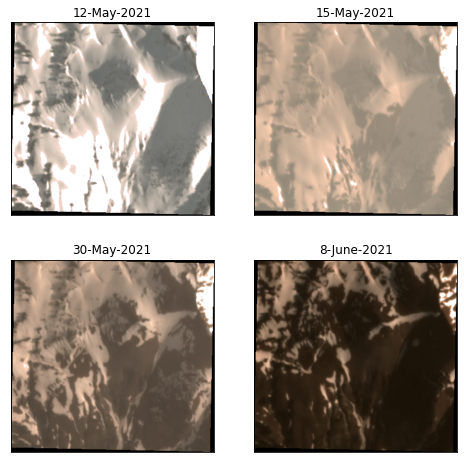

In [93]:
fg,ax = plt.subplots(2,2,figsize=(8,7))
ax = np.ravel(ax)

for fCount,file in enumerate(files):
    ds = rxr.open_rasterio(base_direc+file)
    
    # Selecting RGB bands
    blue_band = ds.isel(band=0)
    green_band = ds.isel(band=1)
    red_band = ds.isel(band=2)
    
    # maxval = np.max(np.array([blue_band.max().values,green_band.max().values,red_band.max().values]))
    # minval = np.min(np.array([blue_band.min().values,green_band.min().values,red_band.min().values]))
    maxval = green_band.max().values
    minval = green_band.min().values

    # # Normalizing the bands
    # red_norm = (red_band - red_band.min()) / (red_band.max() - red_band.min())
    # green_norm = (green_band - green_band.min()) / (green_band.max() - green_band.min())
    # blue_norm = (blue_band - blue_band.min()) / (blue_band.max() - blue_band.min())
    red_norm = (red_band - minval) / (maxval - minval)
    green_norm = (green_band - minval) / (maxval - minval)
    blue_norm = (blue_band - minval) / (maxval - minval)
    green_norm = green_norm.where(red_norm <= 1,1)
    blue_norm = blue_norm.where(red_norm <= 1,1)
    red_norm = red_norm.where(red_norm <= 1,1)
    
    # vmax = red_norm.values
    # vmax[vmax == 0] = np.nan
    # vmax[vmax == 1] = np.nan
    # vmax = np.nanmax(vmax)
    
    # Stack normalized bands to create RGB image
    rgb_image = np.stack([red_norm, green_norm, blue_norm], axis=-1)

    ax[fCount].imshow(rgb_image,cmap='Greys',vmin=0,vmax=1)
    ax[fCount].set_xticks([])
    ax[fCount].set_yticks([])
    ax[fCount].set_title(dates[fCount])
    
    # break

In [84]:
test = green_norm.values
test[test == 0] = np.nan
test[test == 1] = np.nan
np.nanmax(test)

0.8105386809867428

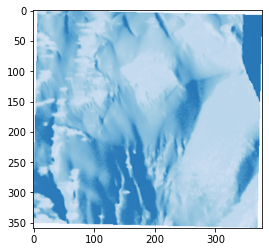

In [48]:
plt.imshow(blue_norm,vmin=0,vmax=1,cmap='Blues')

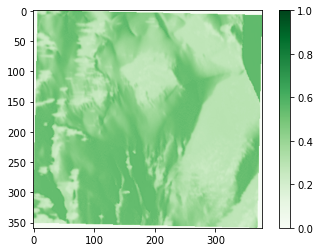

In [47]:
plt.imshow(green_norm,vmin=0,vmax=1,cmap='Greens')
plt.colorbar()

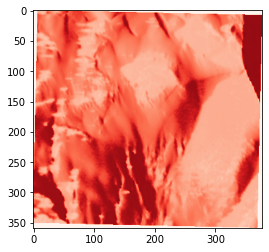

In [49]:
plt.imshow(red_norm,vmin=0,vmax=1,cmap='Reds')

(array([90913., 18976.,  8999.,  8322.,  5725.,  1726.,   421.,   263.,
          255.,   102.]),
 array([0.        , 0.0970297 , 0.19405941, 0.29108911, 0.38811881,
        0.48514851, 0.58217822, 0.67920792, 0.77623762, 0.87326733,
        0.97029703]),
 <BarContainer object of 10 artists>)

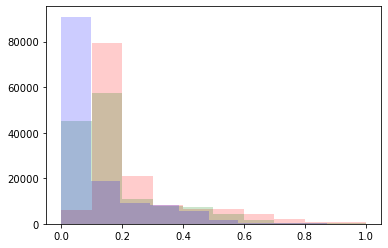

In [76]:
plt.hist(np.ravel(red_norm),alpha=0.2,color='r')
plt.hist(np.ravel(green_norm),alpha=0.2,color='g')
plt.hist(np.ravel(blue_norm),alpha=0.2,color='b')